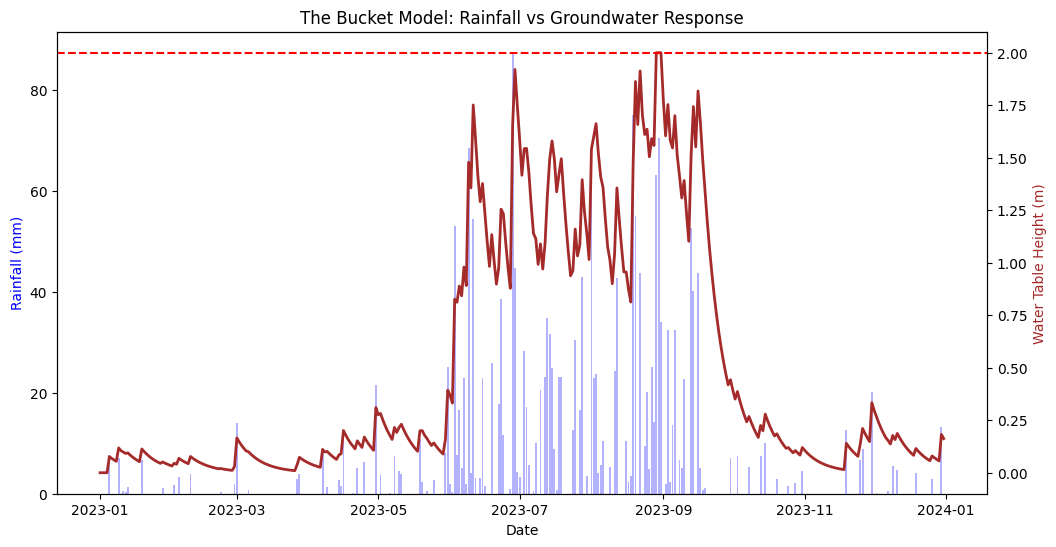

In [57]:
# for synthetic rainfall, via AI

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 1. Generate Time Series (1 Year)
dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
df = pd.DataFrame({'date': dates})

# 2. Generate Synthetic Rainfall (The Monsoon)
# We want dry winter, wet summer (June-Sept)
def generate_rain(day_of_year):
    # Gaussian bell curve centered on day 200 (July)
    # Peak rain probability around monsoon
    if 150 < day_of_year < 260:
        return np.random.exponential(scale=20.0) * np.random.choice([0, 1], p=[0.3, 0.7])
    else:
        return np.random.exponential(scale=5.0) * np.random.choice([0, 1], p=[0.8, 0.2])

df['day_of_year'] = df['date'].dt.dayofyear
df['rain_mm'] = df['day_of_year'].apply(generate_rain).fillna(0)

# 3. The Bucket Model (Simple Groundwater Model)
# Assumptions:
# - k_drain: % of water that drains away daily (e.g., 5%)
# - alpha: Conversion factor (100mm rain raises water table by X meters)
k_drain = 0.11
alpha = 0.01
water_table = [0.0]

for i in range(1, len(df)):
    # Previous water level - Drainage + New Rain impact
    # Water table cannot drop below 0
    prev_h = water_table[-1]
    rain_input = df.loc[i, 'rain_mm']

    new_h = prev_h * (1 - k_drain) + (rain_input * alpha)

    # Cap the water table at the surface (Depth = 2.0m)
    new_h = min(new_h, 2.0)
    water_table.append(new_h)

df['water_height_m'] = water_table

# 4. Visualize the Hydro-Response
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Rainfall (mm)', color='blue')
ax1.bar(df['date'], df['rain_mm'], color='blue', alpha=0.3, label='Rain')

ax2 = ax1.twinx()
ax2.set_ylabel('Water Table Height (m)', color='brown')
ax2.plot(df['date'], df['water_height_m'], color='brown', linewidth=2, label='Water Table')
ax2.axhline(y=2.0, color='red', linestyle='--', label='Surface (Saturation)')

plt.title('The Bucket Model: Rainfall vs Groundwater Response')
plt.show()

In [58]:
import numpy as np


def calc_FoS(
        c_prime, gamma_soil, depth, slope_angle_degree, depth_water, phi_prime_degree
):

    i = np.radians(slope_angle_degree)

    gamma_water = 9.81  # kN/m3

    x =    (gamma_soil*depth - gamma_water*depth_water)  *(np.cos(i)*np.cos(i))

    phi_prime_rad = np.radians(phi_prime_degree)

    strength = c_prime + (x * np.tan(phi_prime_rad))



    stress = (gamma_soil*depth*np.sin(i)*np.cos(i))

    FoS = strength/stress

    return FoS



Total Days of Failure Conditions: 7
Annual Probability of Failure: 1.918%


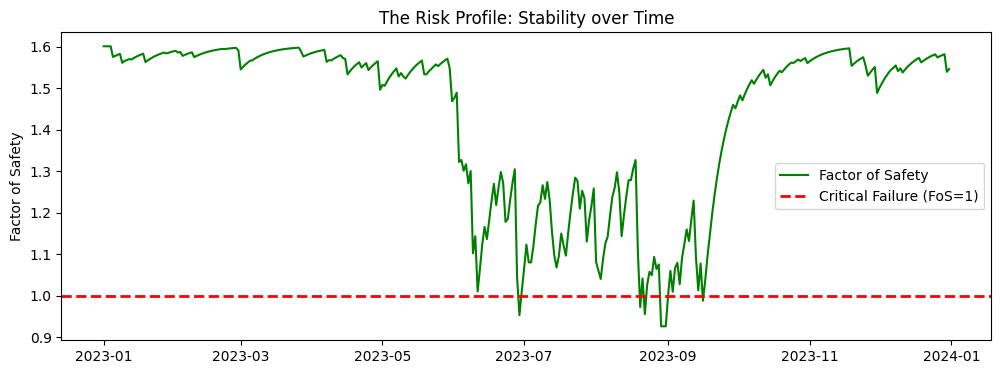

In [59]:
# Constants
C_PRIME = 5.0
PHI = 30
SLOPE = 25
UNIT_WEIGHT = 18.0
DEPTH = 2.0

# Vectorized Calculation (Fast)
# We can pass the whole column 'df['water_height_m']' into the function!
# But our function uses `np.radians` which expects arrays, so it should work.
# Let's wrap it in a lambda to be safe or just apply it.

df['fos'] = df.apply(
    lambda row: calc_FoS(
        c_prime=C_PRIME,
        phi_prime_degree=PHI,
        slope_angle_degree=SLOPE,
        gamma_soil=UNIT_WEIGHT,
        depth=DEPTH,
        depth_water=row['water_height_m']
    ), axis=1
)

# The Verdict
failed_days = df[df['fos'] < 1.0].shape[0]
probability_of_failure = (failed_days / 365) * 100

print(f"Total Days of Failure Conditions: {failed_days}")
print(f"Annual Probability of Failure: {probability_of_failure:.3f}%")

# Visualize the Risk
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['fos'], color='green', label='Factor of Safety')
plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Critical Failure (FoS=1)')
plt.ylabel('Factor of Safety')
plt.title('The Risk Profile: Stability over Time')
plt.legend()
plt.show()